In [271]:
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session
from sagemaker.inputs import TrainingInput


In [181]:
bucket_name = 'hemanta221s3bucket' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)

us-east-1


In [182]:
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


In [183]:
# set an output path where the trained model will be saved
prefix = 'xgboost-as-a-built-in-algo'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://hemanta221s3bucket/xgboost-as-a-built-in-algo/output


In [5]:
!pip install -q kaggle

In [6]:
mkdir ~/.kaggle

mkdir: cannot create directory ‘/home/ec2-user/.kaggle’: File exists


In [7]:
!touch ~/.kaggle/kaggle.json

In [8]:
api_token = {"username":"hemantarijal","key":"293105a79539c7b29cdcf4561008dee2"}

In [9]:
!chmod 600 ~/.kaggle/kaggle.json


In [184]:
import os
import json

config_path = os.path.expanduser('~/.kaggle/kaggle.json')

with open(config_path, 'w') as file:
    json.dump(api_token,file)


In [185]:
with open(config_path, 'r') as file:
    print(file.read())

{"username": "hemantarijal", "key": "293105a79539c7b29cdcf4561008dee2"}


In [186]:
!chmod 600 ~/.kaggle/kaggle.json

In [187]:
!kaggle datasets download -d rinichristy/2022-fuel-consumption-ratings --force

  0%|                                               | 0.00/13.4k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 13.4k/13.4k [00:00<00:00, 30.8MB/s]


In [188]:
ls

2022-fuel-consumption-ratings.zip  data/    lost+found/  train.csv
Amazon_Sagemaker.ipynb             kaggle/  test.csv


In [189]:
import zipfile
with zipfile.ZipFile('./2022-fuel-consumption-ratings.zip','r') as zip_ref:
    zip_ref.extractall('./data')

In [190]:
#load data into dataframe 
import pandas as pd


In [191]:
try:
    data = pd.read_csv('./data/MY2022 Fuel Consumption Ratings.csv',index_col=0)
    print('data loaded into dataframe')
except Exception as e:
    print('Import error: ',e)
    

data loaded into dataframe


In [239]:
data.head()

,Make,VehicleClass,EngineSize,Transmission,FuelType,C02emissions,smogRating
Model Year,,,,,,,
2022,0,0,2.4,7,3,200,3
2022,0,7,3.5,8,3,263,5
2022,0,7,2.0,8,3,232,6
2022,0,7,2.0,8,3,242,6
2022,0,0,2.0,8,3,230,7


In [153]:
# data exploration

In [193]:
#shape of the data
print("shape of data")
data.shape

shape of data


(946, 14)

In [194]:
#checking the unique value from columns
data.nunique()

Make                                  39
Model                                715
Vehicle Class                         14
Engine Size(L)                        36
Cylinders                              8
Transmission                          23
Fuel Type                              4
Fuel Consumption (City (L/100 km)    149
Fuel Consumption(Hwy (L/100 km))     107
Fuel Consumption(Comb (L/100 km))    131
Fuel Consumption(Comb (mpg))          49
CO2 Emissions(g/km)                  242
CO2 Rating                            10
Smog Rating                            5
dtype: int64

In [195]:
# we dont need model year in the value since all of  this data from 2014.
data = data.drop(['Model'],axis=1)

In [196]:
data.isnull().sum()

Make                                 0
Vehicle Class                        0
Engine Size(L)                       0
Cylinders                            0
Transmission                         0
Fuel Type                            0
Fuel Consumption (City (L/100 km)    0
Fuel Consumption(Hwy (L/100 km))     0
Fuel Consumption(Comb (L/100 km))    0
Fuel Consumption(Comb (mpg))         0
CO2 Emissions(g/km)                  0
CO2 Rating                           0
Smog Rating                          0
dtype: int64

In [197]:
data.describe()

,Engine Size(L),Cylinders,Fuel Consumption (City (L/100 km),Fuel Consumption(Hwy (L/100 km)),Fuel Consumption(Comb (L/100 km)),Fuel Consumption(Comb (mpg)),CO2 Emissions(g/km),CO2 Rating,Smog Rating
count,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000
mean,3.198732,5.668076,12.506448,9.363319,11.092072,27.247357,259.172304,4.539112,4.950317
std,1.374814,1.932670,3.452043,2.285125,2.876276,7.685217,64.443149,1.471799,1.679842
min,1.200000,3.000000,4.000000,3.900000,4.000000,11.000000,94.000000,1.000000,1.000000
25%,2.000000,4.000000,10.200000,7.700000,9.100000,22.000000,213.250000,3.000000,3.000000
50%,3.000000,6.000000,12.200000,9.200000,10.800000,26.000000,257.000000,5.000000,5.000000
75%,3.800000,6.000000,14.700000,10.700000,12.900000,31.000000,300.750000,5.000000,6.000000
max,8.000000,16.000000,30.300000,20.900000,26.100000,71.000000,608.000000,10.000000,7.000000


In [198]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 946 entries, 2022 to 2022
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Make                               946 non-null    object 
 1   Vehicle Class                      946 non-null    object 
 2   Engine Size(L)                     946 non-null    float64
 3   Cylinders                          946 non-null    int64  
 4   Transmission                       946 non-null    object 
 5   Fuel Type                          946 non-null    object 
 6   Fuel Consumption (City (L/100 km)  946 non-null    float64
 7   Fuel Consumption(Hwy (L/100 km))   946 non-null    float64
 8   Fuel Consumption(Comb (L/100 km))  946 non-null    float64
 9   Fuel Consumption(Comb (mpg))       946 non-null    int64  
 10  CO2 Emissions(g/km)                946 non-null    int64  
 11  CO2 Rating                         946 non-null    int64  


In [199]:
data.rename(columns = {
                        'CO2 Emissions(g/km)':'C02emissions',
                        'Vehicle Class':'VehicleClass',
                        'Engine Size(L)':'EngineSize',
                        'Fuel Type':'FuelType',
                        'Fuel Consumption (City (L/100 km)':'FuelConsumptionCity',
                        'Fuel Consumption(Hwy (L/100 km))':'FuelConsumptionHwy',
                        'Fuel Consumption(Comb (L/100 km))':'FuelConsumptionComb',
                        'Fuel Consumption(Comb (mpg))':'FuelConsumptionCombMpg',
                        'CO2 Rating':'C02Rating',
                        'Smog Rating':'smogRating'
                      }, inplace = True)

In [201]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 946 entries, 2022 to 2022
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Make                    946 non-null    object 
 1   VehicleClass            946 non-null    object 
 2   EngineSize              946 non-null    float64
 3   Cylinders               946 non-null    int64  
 4   Transmission            946 non-null    object 
 5   FuelType                946 non-null    object 
 6   FuelConsumptionCity     946 non-null    float64
 7   FuelConsumptionHwy      946 non-null    float64
 8   FuelConsumptionComb     946 non-null    float64
 9   FuelConsumptionCombMpg  946 non-null    int64  
 10  C02emissions            946 non-null    int64  
 11  C02Rating               946 non-null    int64  
 12  smogRating              946 non-null    int64  
dtypes: float64(4), int64(5), object(4)
memory usage: 103.5+ KB


In [202]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/tmp/ipykernel_32579/633934980.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(data['C02emissions'], kde = True, color = 'c')


Text(0.5, 1.0, 'Distribution of CO2EMISSIONS')

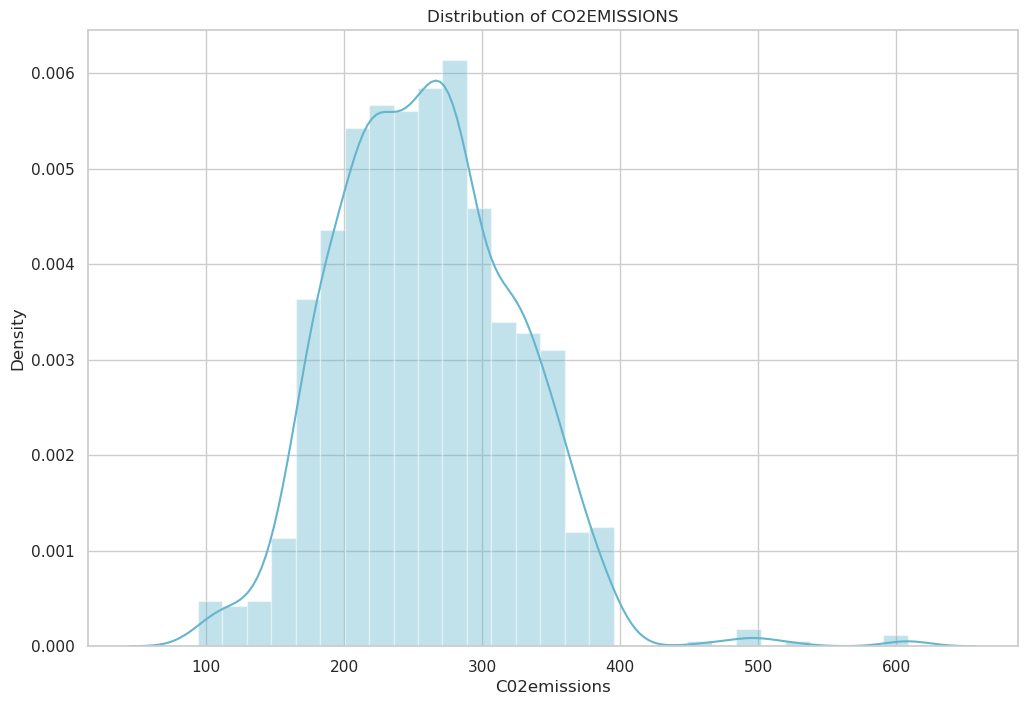

In [203]:
sns.set(style='whitegrid')
f, ax = plt.subplots(1,1, figsize=(12, 8))
ax = sns.distplot(data['C02emissions'], kde = True, color = 'c')
plt.title('Distribution of CO2EMISSIONS')

In [204]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 946 entries, 2022 to 2022
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Make                    946 non-null    object 
 1   VehicleClass            946 non-null    object 
 2   EngineSize              946 non-null    float64
 3   Cylinders               946 non-null    int64  
 4   Transmission            946 non-null    object 
 5   FuelType                946 non-null    object 
 6   FuelConsumptionCity     946 non-null    float64
 7   FuelConsumptionHwy      946 non-null    float64
 8   FuelConsumptionComb     946 non-null    float64
 9   FuelConsumptionCombMpg  946 non-null    int64  
 10  C02emissions            946 non-null    int64  
 11  C02Rating               946 non-null    int64  
 12  smogRating              946 non-null    int64  
dtypes: float64(4), int64(5), object(4)
memory usage: 103.5+ KB


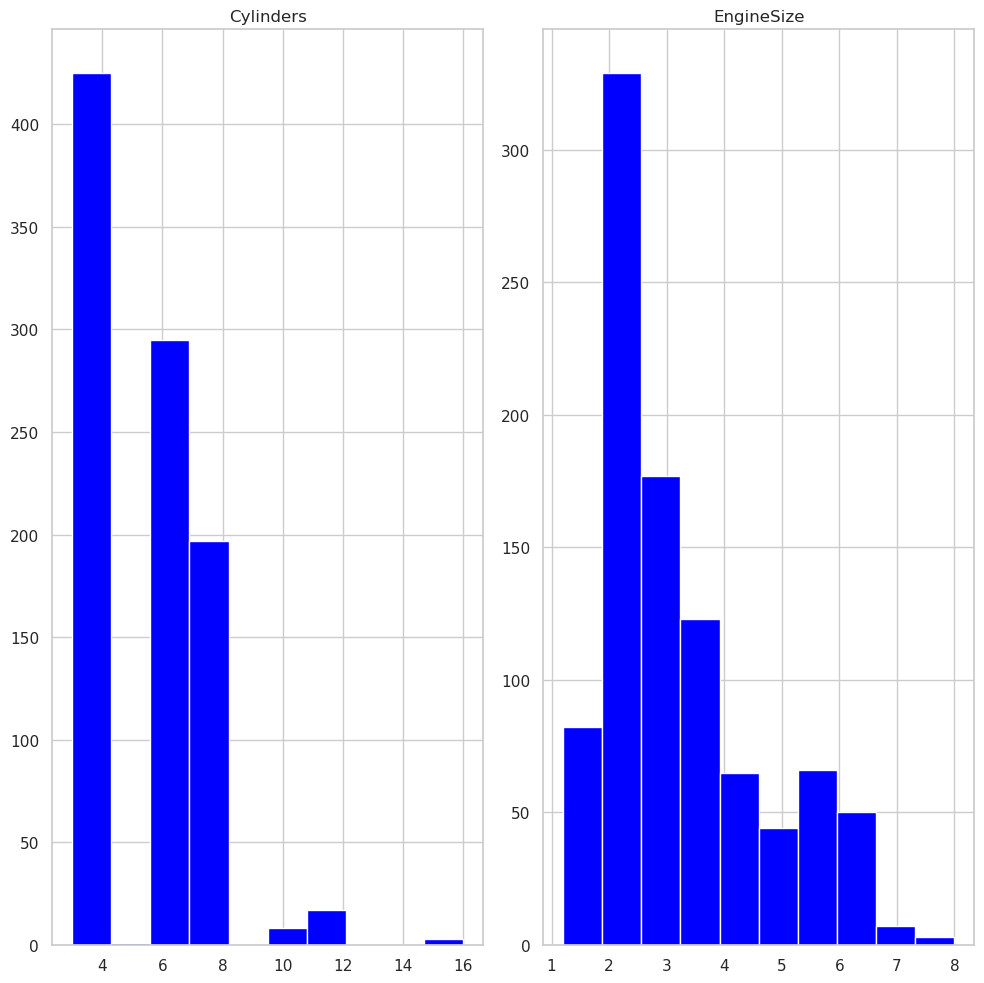

In [205]:
viz = data[['Cylinders','EngineSize']]
viz.hist(color = 'Blue', figsize = (10, 10))
plt.tight_layout();
plt.show();

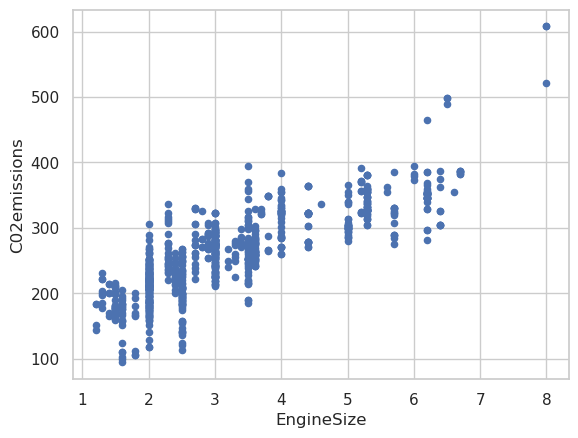

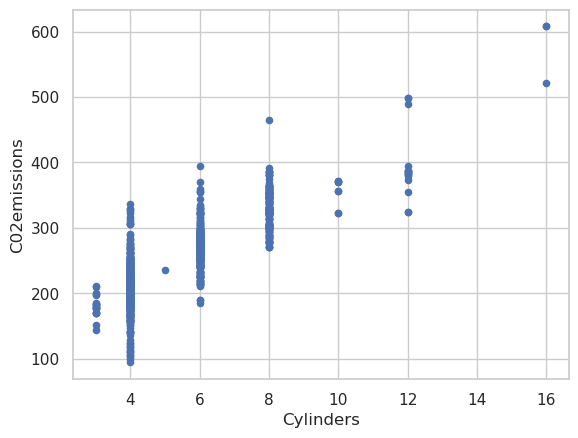

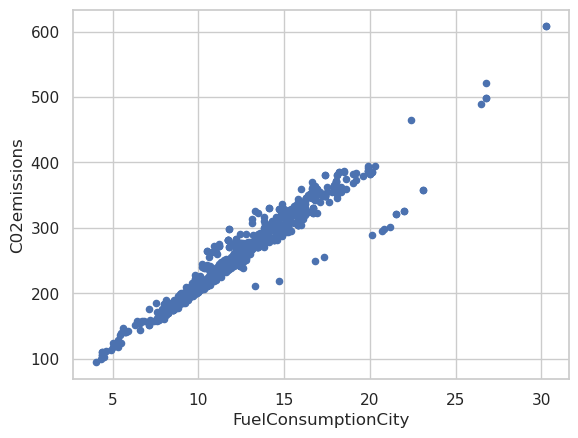

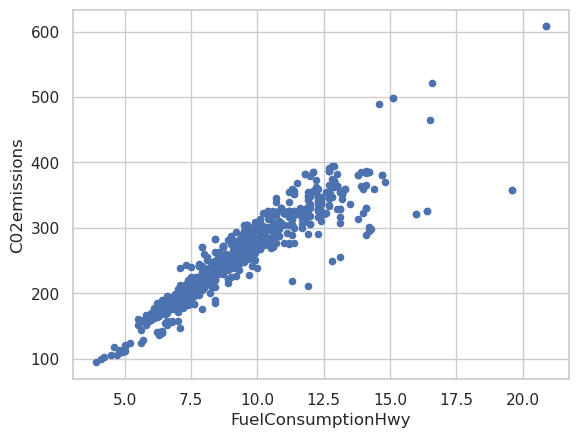

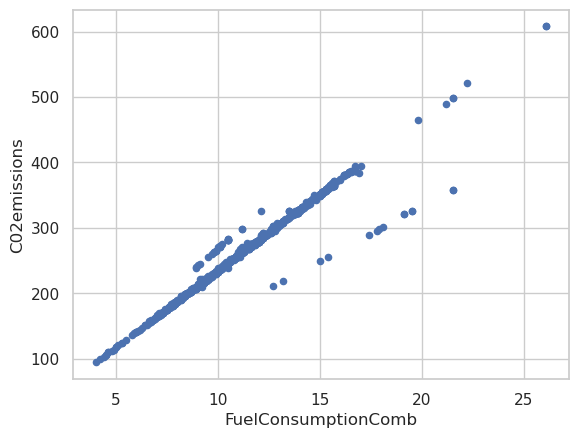

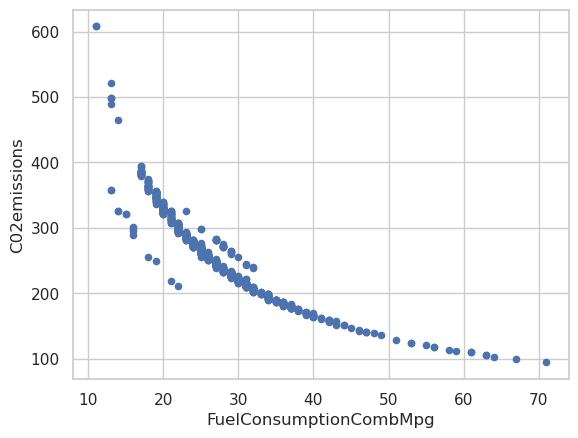

In [206]:
# this visualization helps to hind correlation between each columns
data.plot(kind='scatter', x='EngineSize', y='C02emissions')
data.plot(kind='scatter', x='Cylinders', y='C02emissions')
data.plot(kind='scatter', x='FuelConsumptionCity', y='C02emissions')
data.plot(kind='scatter', x='FuelConsumptionHwy', y='C02emissions')
data.plot(kind='scatter', x='FuelConsumptionComb', y='C02emissions')
data.plot(kind='scatter', x='FuelConsumptionCombMpg', y='C02emissions')
plt.show()

Text(0.5, 1.0, 'Carbon Emission by Make')

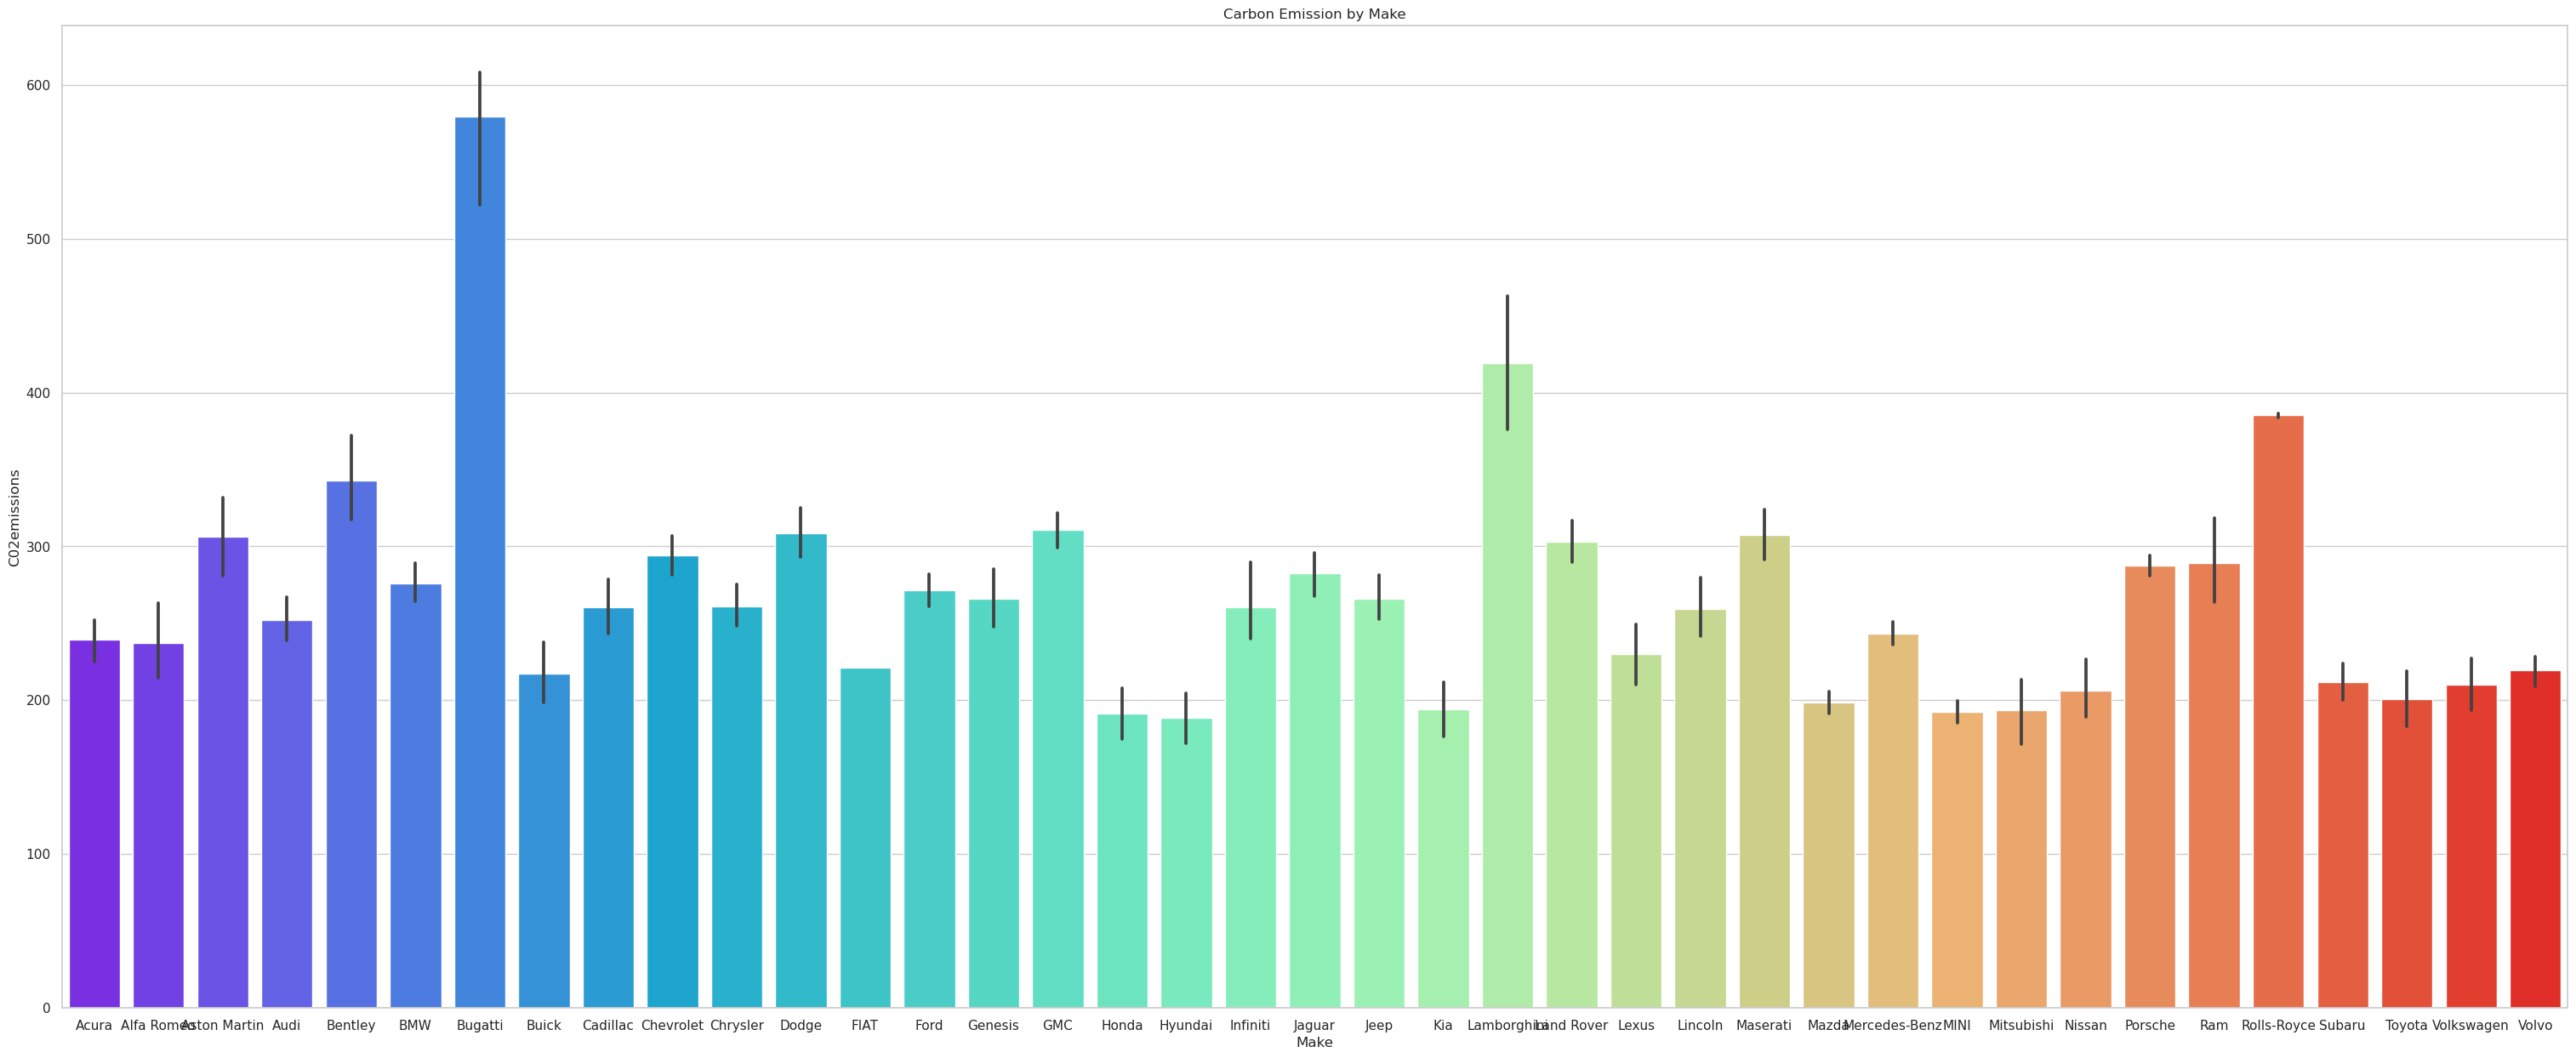

In [207]:
plt.figure(figsize=(38,15))
sns.barplot(x='Make',y='C02emissions',data=data, palette='rainbow')
plt.title("Carbon Emission by Make")

Text(0.5, 1.0, 'Carbon Emission by Make')

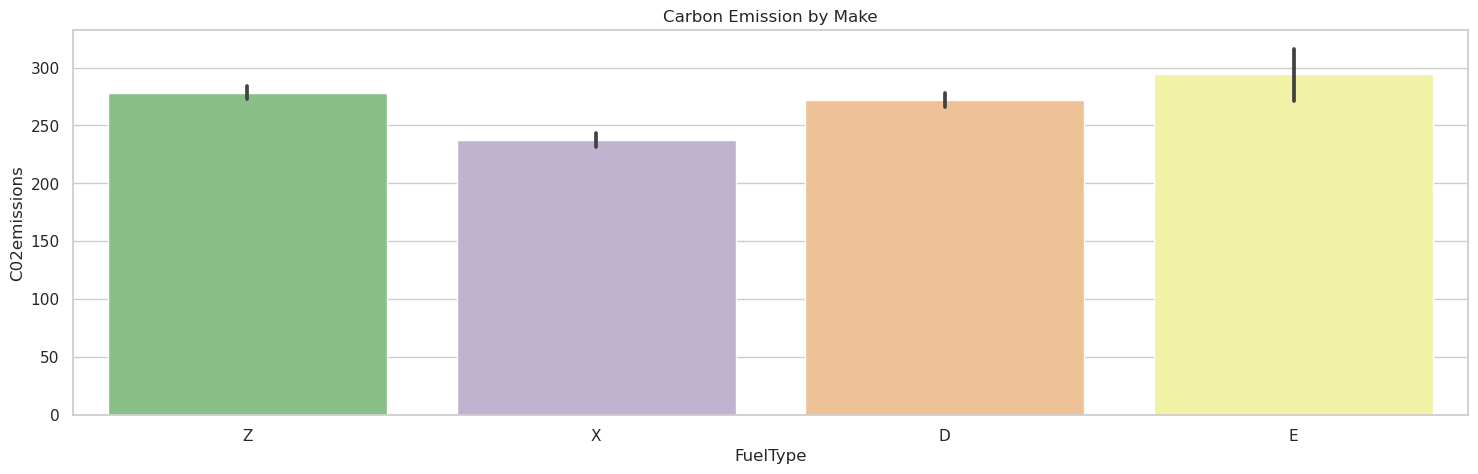

In [208]:
plt.figure(figsize=(18,5))
sns.barplot(x='FuelType',y='C02emissions',data=data, palette='Accent')
plt.title("Carbon Emission by Make")

Text(0.5, 1.0, 'Carbon Emission by Transmission')

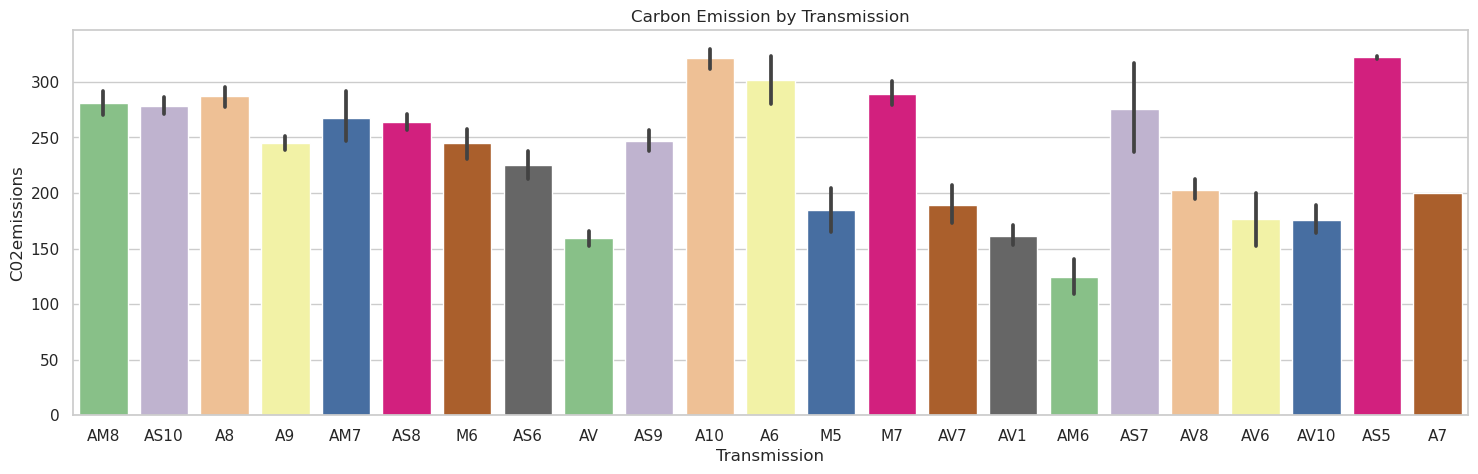

In [209]:
plt.figure(figsize=(18,5))
sns.barplot(x='Transmission',y='C02emissions',data=data, palette='Accent')
plt.title("Carbon Emission by Transmission")

Text(0.5, 1.0, 'Carbon Emission by Vehicle Class')

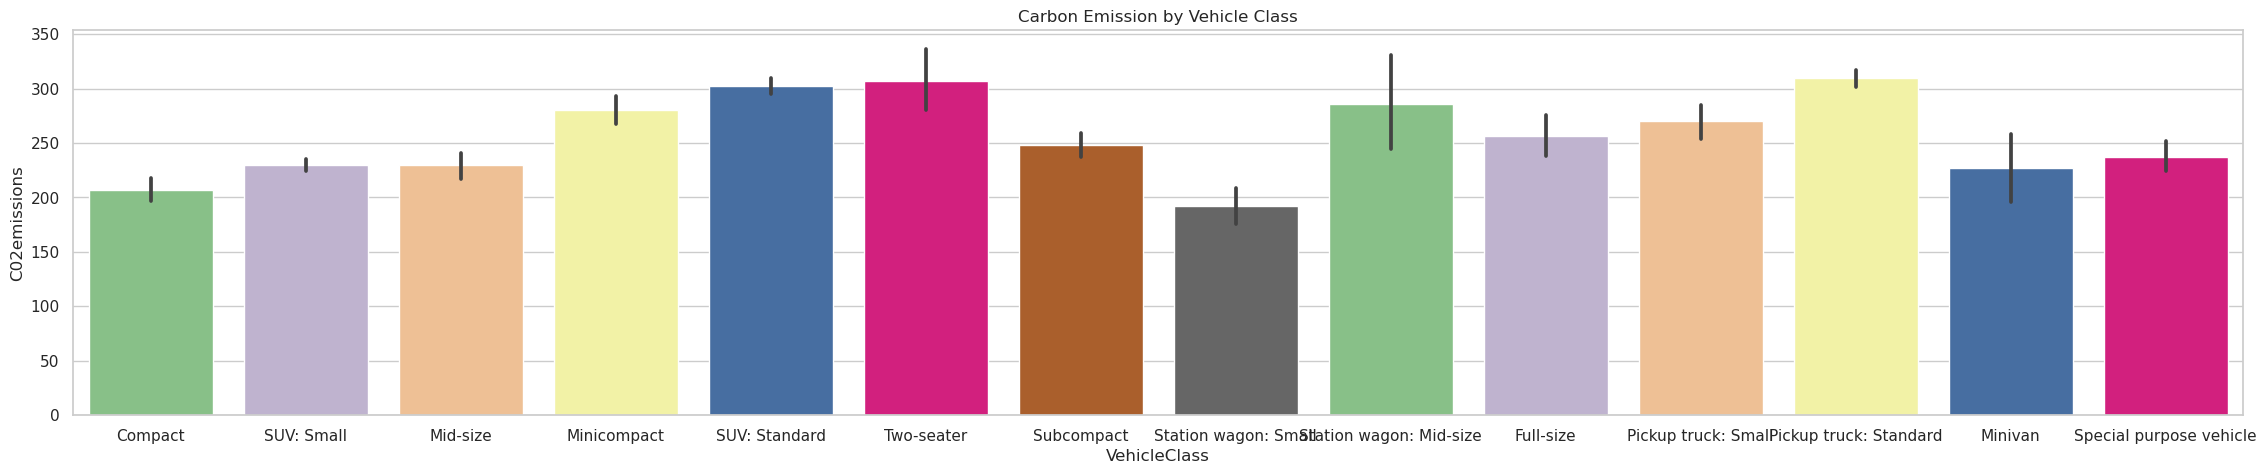

In [210]:
plt.figure(figsize=(28,5))
sns.barplot(x='VehicleClass',y='C02emissions',data=data, palette='Accent')
plt.title("Carbon Emission by Vehicle Class")

# Label Encoding

In [211]:
from sklearn.preprocessing import LabelEncoder  #encoding (we convert categorical variables into Numeric)
lb=LabelEncoder() 

In [212]:
data['FuelType']=lb.fit_transform(data['FuelType'])
data['Make']= lb.fit_transform(data['Make'])
data['VehicleClass']= lb.fit_transform(data['VehicleClass'])
data['Transmission']= lb.fit_transform(data['Transmission'])

In [213]:
data

,Make,VehicleClass,EngineSize,Cylinders,Transmission,FuelType,FuelConsumptionCity,FuelConsumptionHwy,FuelConsumptionComb,FuelConsumptionCombMpg,C02emissions,C02Rating,smogRating
Model Year,,,,,,,,,,,,,
2022,0,0,2.4,4,7,3,9.9,7.0,8.6,33,200,6,3
2022,0,7,3.5,6,8,3,12.6,9.4,11.2,25,263,4,5
2022,0,7,2.0,4,8,3,11.0,8.6,9.9,29,232,5,6
2022,0,7,2.0,4,8,3,11.3,9.1,10.3,27,242,5,6
2022,0,0,2.0,4,8,3,11.2,8.0,9.8,29,230,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022,38,7,2.0,4,12,3,10.7,7.7,9.4,30,219,5,5
2022,38,7,2.0,4,12,3,10.5,8.1,9.4,30,219,5,5
2022,38,7,2.0,4,12,3,11.0,8.7,9.9,29,232,5,7


## Finding Correleation between data

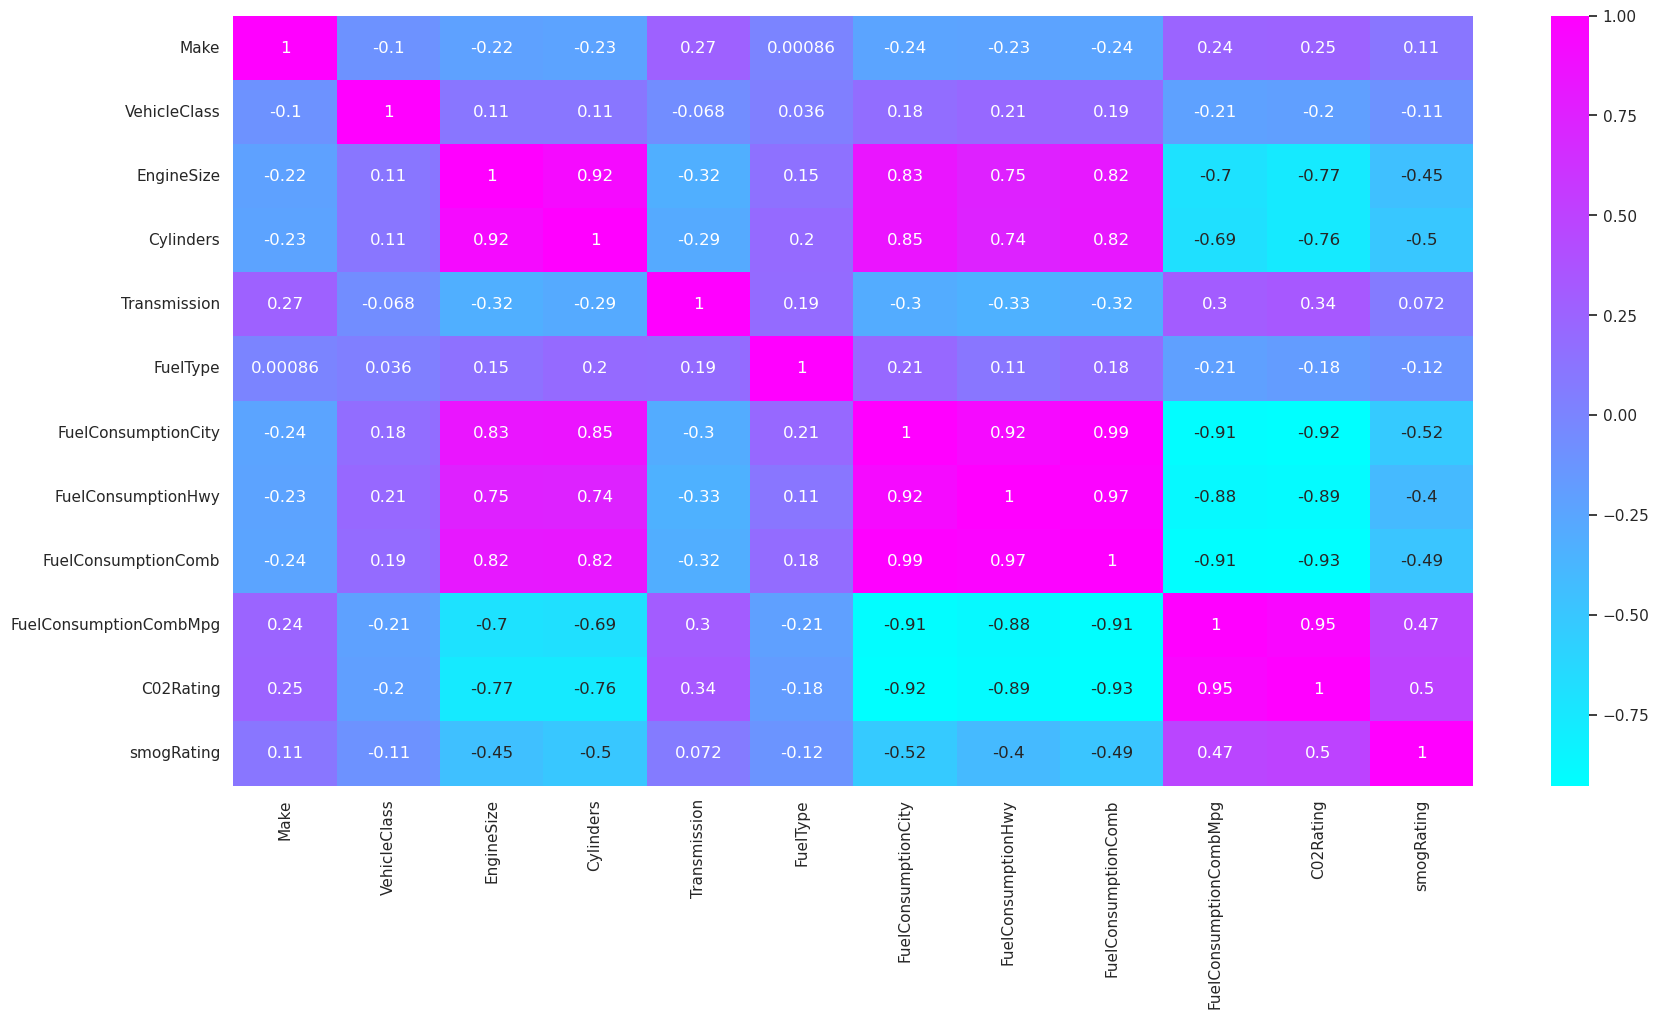

In [214]:
data2 = data.drop('C02emissions',axis='columns')
#corelation
f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.heatmap(data2.corr(), annot=True, cmap='cool')

In [215]:
import numpy as np

#### We are removing the all correlation data which correlation is above 0.80

In [216]:
# Create correlation matrix
corr_matrix = data2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

to_drop

/tmp/ipykernel_32579/354430140.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


['Cylinders',
 'FuelConsumptionCity',
 'FuelConsumptionHwy',
 'FuelConsumptionComb',
 'FuelConsumptionCombMpg',
 'C02Rating']

In [217]:
# col_to_drop= ['FUELCONSUMPTION_HWY','FUELCONSUMPTION_COMB','CYLINDERS'];
data = data.drop(to_drop,axis=1)

In [218]:
data.head()

,Make,VehicleClass,EngineSize,Transmission,FuelType,C02emissions,smogRating
Model Year,,,,,,,
2022,0,0,2.4,7,3,200,3
2022,0,7,3.5,8,3,263,5
2022,0,7,2.0,8,3,232,6
2022,0,7,2.0,8,3,242,6
2022,0,0,2.0,8,3,230,7


In [220]:
# X=data.drop('C02emissions',axis='columns')
# X.head()
X = data

standarize the range of functinality using standardScaler

In [221]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [222]:
y=data['C02emissions']
y.head()

Model Year
2022    200
2022    263
2022    232
2022    242
2022    230
Name: C02emissions, dtype: int64

### Split the dataset into train and test

In [231]:
#split the data into train and test set
train,test = train_test_split(data, test_size=0.30, random_state=0)
#save the data
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

In [320]:
train

,Make,VehicleClass,EngineSize,Transmission,FuelType,C02emissions,smogRating
Model Year,,,,,,,
2022,18,2,3.0,11,3,261,3
2022,38,11,2.0,12,3,221,5
2022,38,10,2.0,12,3,222,7
2022,4,7,2.0,12,3,230,7
2022,4,1,3.0,12,3,219,5
...,...,...,...,...,...,...,...
2022,33,6,5.7,3,2,323,3
2022,9,7,1.5,1,2,208,7
2022,27,1,3.8,3,3,348,1


In [322]:
pd.concat([train['C02emissions'], train.drop(['C02emissions'], 
                                                axis=1)], 
                                                axis=1).to_csv('train.csv', index=False, header=False)

In [275]:
# Uploading the train.csv file to S3 bucket
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')

# Creating an S3 input for training
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [276]:
pd.concat([test['C02emissions'], test.drop(['C02emissions'], 
                                                axis=1)], 
                                                axis=1).to_csv('test.csv', index=False, header=False)

In [277]:
# Uploading the train.csv file to S3 bucket
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')

# Creating an S3 input for training
s3_input_test = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [278]:
container = get_image_uri(boto3.Session().region_name,
                          'xgboost', 
                          repo_version='1.0-1')

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [279]:

# initialize hyperparameters
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "num_round":50
        }
     


In [280]:

# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m5.2xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path,
                                          use_spot_instances=True,
                                          max_run=300,
                                          max_wait=600)

In [281]:
estimator.fit({'train': s3_input_train,'validation': s3_input_test})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-07-21-06-16-51-002


2023-07-21 06:16:51 Starting - Starting the training job...
2023-07-21 06:17:06 Starting - Preparing the instances for training......
2023-07-21 06:18:02 Downloading - Downloading input data...
2023-07-21 06:18:43 Training - Training image download completed. Training in progress....
2023-07-21 06:19:13 Uploading - Uploading generated training model[2023-07-21 06:19:06.260 ip-10-0-112-19.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Single node training.
[06:19:06] 662x6 matrix with 3972 entries loaded from /opt/ml/i

### Deploy Machine Learning Model As Endpoints

In [282]:
xgb_predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-07-21-06-21-41-848
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-07-21-06-21-41-848
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-07-21-06-21-41-848


-------!

In [285]:
# Create a SageMaker client
sagemaker_client = sagemaker.Session().sagemaker_client

# List the endpoints
response = sagemaker_client.list_endpoints()

# Extract the endpoint names
endpoint_names = [endpoint['EndpointName'] for endpoint in response['Endpoints']]

# Print the endpoint names
for endpoint_name in endpoint_names:
    print(endpoint_name)

sagemaker-xgboost-2023-07-21-06-21-41-848
sagemaker-xgboost-2023-07-18-20-19-36-921
sagemaker-xgboost-2023-07-18-18-09-38-731


In [333]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

test_data_array = test.drop(['C02emissions'], axis=1).values

# predictor = Predictor(endpoint_name='sagemaker-xgboost-2023-07-18-18-09-38-731',
#                       serializer=CSVSerializer(),
#                       deserializer=JSONDeserializer())

# Create the Predictor object
predictor = sagemaker.predictor.Predictor(endpoint_name='sagemaker-xgboost-2023-07-18-18-09-38-731',
                                          serializer=sagemaker.serializers.CSVSerializer(),
                                          deserializer=sagemaker.deserializers.CSVDeserializer(),
                                          content_types='text/csv',
                                          label_size=0)


# predictor.predict(test_data_array)

In [357]:
response = predictor.predict(test_data_array)
response

[['28.692819595336914',
  '18.951196670532227',
  '23.99067497253418',
  '23.99067497253418',
  '24.50908851623535',
  '15.279610633850098',
  '17.378477096557617',
  '21.872861862182617',
  '21.00136375427246',
  '17.836971282958984',
  '32.91168975830078',
  '22.49835968017578',
  '18.219127655029297',
  '23.99067497253418',
  '17.98160743713379',
  '17.464210510253906',
  '22.49835968017578',
  '19.790830612182617',
  '23.99067497253418',
  '25.142520904541016',
  '15.356147766113281',
  '27.69283676147461',
  '23.99067497253418',
  '17.201501846313477',
  '10.172903060913086',
  '15.960699081420898',
  '22.08579444885254',
  '21.03374481201172',
  '22.02442741394043',
  '15.356147766113281',
  '26.314199447631836',
  '29.842363357543945',
  '18.790847778320312',
  '16.91456413269043',
  '11.752561569213867',
  '13.091395378112793',
  '20.374845504760742',
  '29.424888610839844',
  '14.31954574584961',
  '25.69536018371582',
  '23.417665481567383',
  '23.417665481567383',
  '15.3561

In [358]:
flattened_list = [item for sublist in response for item in sublist]

In [359]:
predictions_array = np.array(flattened_list)

In [360]:
predictions_array

array(['28.692819595336914', '18.951196670532227', '23.99067497253418',
       '23.99067497253418', '24.50908851623535', '15.279610633850098',
       '17.378477096557617', '21.872861862182617', '21.00136375427246',
       '17.836971282958984', '32.91168975830078', '22.49835968017578',
       '18.219127655029297', '23.99067497253418', '17.98160743713379',
       '17.464210510253906', '22.49835968017578', '19.790830612182617',
       '23.99067497253418', '25.142520904541016', '15.356147766113281',
       '27.69283676147461', '23.99067497253418', '17.201501846313477',
       '10.172903060913086', '15.960699081420898', '22.08579444885254',
       '21.03374481201172', '22.02442741394043', '15.356147766113281',
       '26.314199447631836', '29.842363357543945', '18.790847778320312',
       '16.91456413269043', '11.752561569213867', '13.091395378112793',
       '20.374845504760742', '29.424888610839844', '14.31954574584961',
       '25.69536018371582', '23.417665481567383', '23.41766548156738